# Testing CMD modelling

We are now computing the probabilities using the errors in the data and removing any error from the speedystar simulation. This means that need to find a way to model the 2D distribution of the sharp simulated data.

In this notebook I will test different posibilities to model the CMD of speedystar simulated objects without errors, once we can model them succesfully we can construct a grid ( or straight up model it with a 2D histogram) on this grid we can take the convolution with the measurement errors of the source we want to classify and get the PSF on which the probability of that source is computed.

## Load data

In [1]:
# imports

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit
import matplotlib.colors as colors

import random
import healpy as hp

from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# # Now you can import from the 'scripts' package
# from scripts.implied_d_vr import *  # Or import any other module
# from scripts.selections import *
# from scripts.CMD_selection import *

sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')  # Add scripts folder to path
from scripts.implied_d_vr import *  # Import specific functions or classes as needed
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.catalog_preparation.prepare_gaia import *
from scripts.misc.fft_kde import WeightedFFTKDE

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [24]:
simulation_catalog = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_no_extinction.csv')

In [25]:
simulation_catalog_prepared = prepare_speedystar(Table.from_pandas(simulation_catalog)) # we convert to Table for the function to work

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
X_data = simulation_catalog['Gaia_BP'] - simulation_catalog['Gaia_RP']
Y_data = simulation_catalog['Gaia_G'] -5*np.log10(simulation_catalog.dist*1000) +5

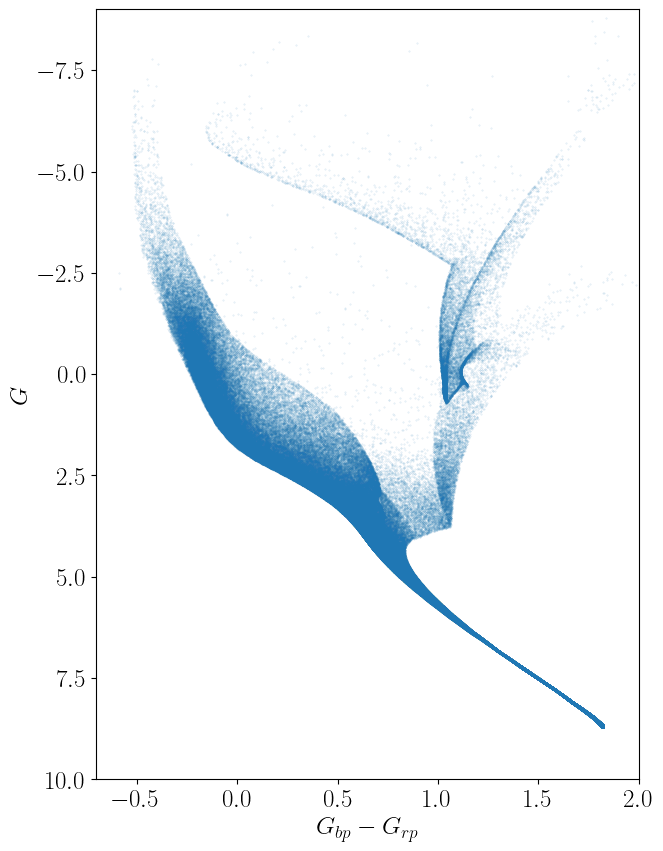

In [68]:
# plot CMD with the exact data
plt.figure(figsize=(7, 10))
plt.scatter(simulation_catalog['Gaia_BP'] - simulation_catalog['Gaia_RP'], 
            simulation_catalog['Gaia_G'] -5*np.log10(simulation_catalog.dist*1000) +5, s=0.1, 
            alpha=0.2, label="Train data")
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G$')
plt.ylim(10, -9)
plt.xlim(-0.7, 2)  
plt.show()

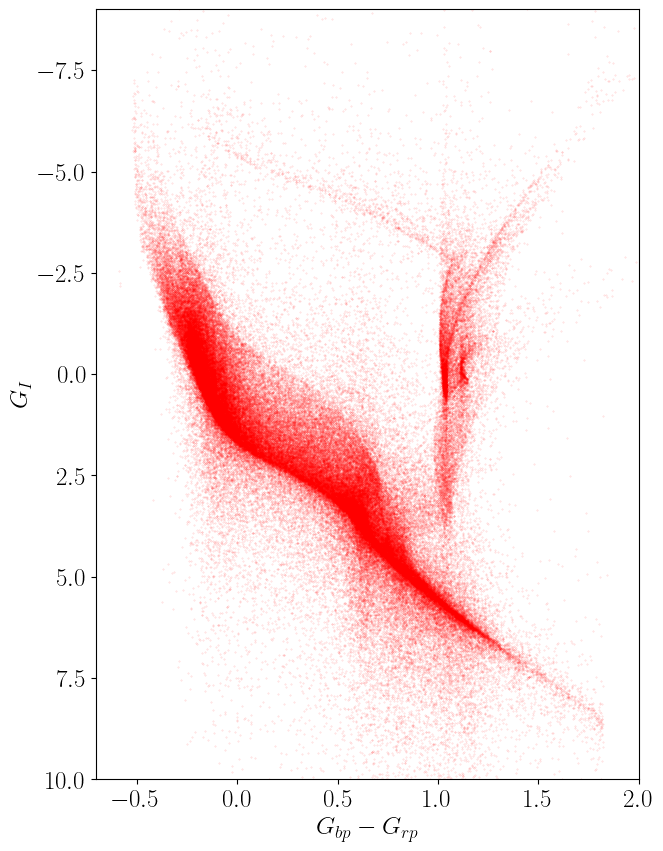

In [28]:
# plot CMD with implied data
plt.figure(figsize=(7, 10))
plt.scatter(simulation_catalog_prepared['bp_rp'], 
            simulation_catalog_prepared['implied_M_g'], s=0.1, 
            alpha=0.2, c='r', label="Train data")
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
plt.ylim(10, -9)
plt.xlim(-0.7, 2)  
plt.show()

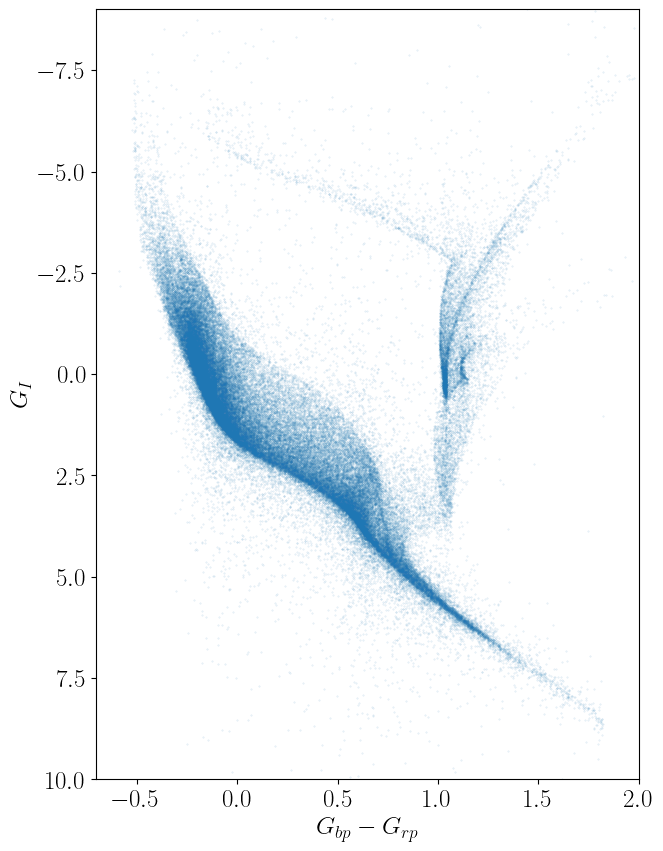

In [69]:
# plot CMD with implied data for only stars that can leave the bulge
simulation_catalog_prepared = simulation_catalog_prepared[simulation_catalog_prepared['v0']>800]
plt.figure(figsize=(7, 10))
plt.scatter(simulation_catalog_prepared['bp_rp'], 
            simulation_catalog_prepared['implied_M_g'], s=0.1, 
            alpha=0.2, label="Train data")
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
plt.ylim(10, -9)
plt.xlim(-0.7, 2)  
plt.show()

# Kernel Density Estimation

In [70]:
# extract XY data
X_data = simulation_catalog_prepared['bp_rp']
Y_data = simulation_catalog_prepared['phot_g_mean_mag'] -5*np.log10(simulation_catalog_prepared.dist*1000) +5#simulation_catalog_prepared['implied_M_g']

In [71]:
# use robut scaler to make it easier to fit
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KernelDensity

# join the data
X = np.array(X_data).reshape(-1, 1)
Y = np.array(Y_data).reshape(-1, 1)
data_2d = np.vstack([X, Y]).T

# Fit the RobustScaler
scaler = RobustScaler()
scaled_data_2d = scaler.fit_transform(data_2d)

# Fit the KDE
kde_class = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(scaled_data_2d)

In [72]:
# Assuming X_data and Y_data are lists or 1D arrays of the same length
X = np.array(X_data).reshape(-1, 1)  # Shape (n_samples, 1)
Y = np.array(Y_data).reshape(-1, 1)  # Shape (n_samples, 1)

# Horizontally stack X and Y to form a 2D array with shape (n_samples, 2)
data_2d = np.hstack([X, Y])

# Fit the scaler and proceed as before
scaler = RobustScaler()
scaled_data_2d = scaler.fit_transform(data_2d)

# Fit the KDE
kde_class = KernelDensity(bandwidth=0.1, kernel='gaussian').fit(scaled_data_2d)

In [73]:
x_range = (-0.7, 2)
y_range = (10, -9)
resolution = 100
# calculate log-likelihoods with the KDEs for a range of data points to plot contours
X_range = np.linspace(x_range[0], x_range[1], resolution)
Y_range = np.linspace(y_range[0], y_range[1], resolution)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# scale with the same scaler
scaled_XY_mesh = scaler.transform(XY_mesh)

log_p_data_given_hvs = kde_class.score_samples(scaled_XY_mesh)


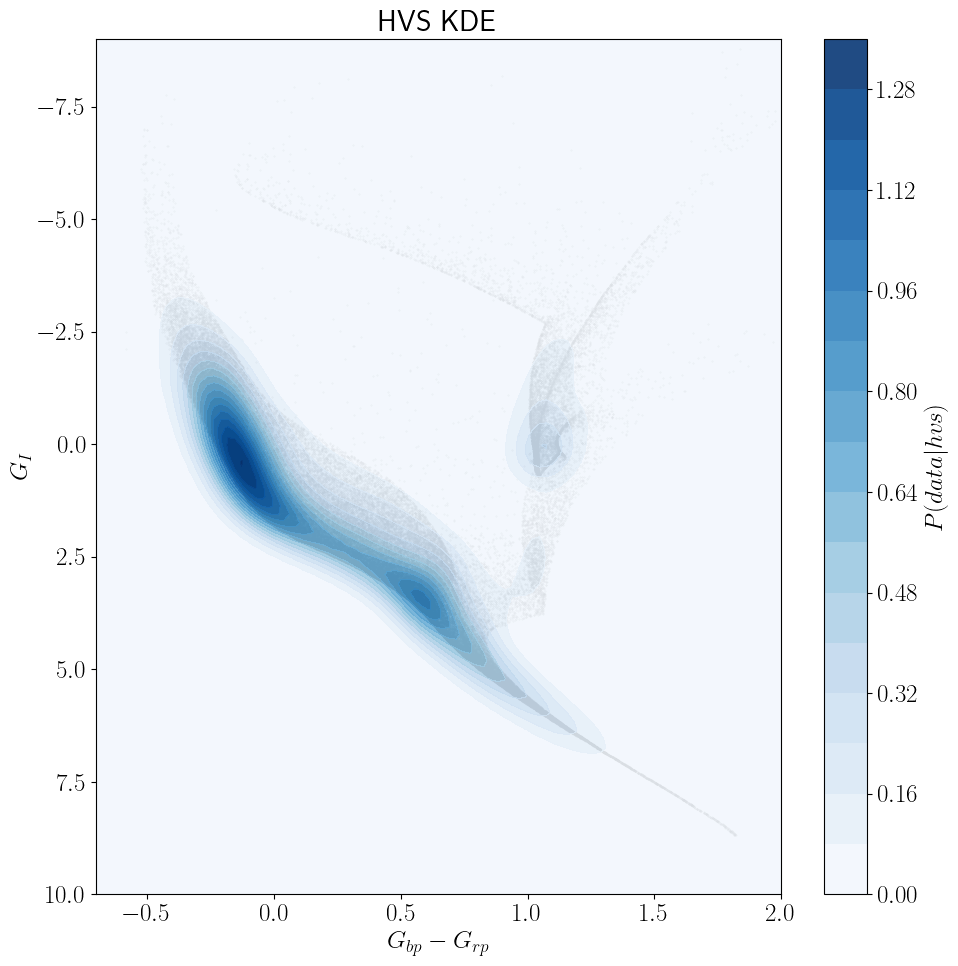

In [81]:

# plot the KDE and the original data for each class
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the "class" data
ax.scatter(X_data, Y_data, s=0.1, c='k', alpha=0.5)
cbar_1 = ax.contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                            cmap='Blues', levels = 20, alpha = 0.9)

ax.set_title('HVS KDE')
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("$G_{bp} - G_{rp}$")
ax.set_ylabel("$G_{I}$")

# # Plot the "not class" data
# ax[1].scatter(self.X_not_class, self.Y_not_class, s=1, c='red', alpha=0.5)
# cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
#                             cmap='Reds', levels = 30, alpha = 0.6)a
# ax[1].set_title('Non-HVS KDE')
# ax[1].set_xlim(x_range)
# ax[1].set_ylim(y_range)
# ax[1].set_xlabel("$G_{bp} - G_{rp}$")
# ax[1].set_ylabel("$G_{I}$")

# add colorbars
fig.colorbar(cbar_1, ax=ax, label = '$P(data|hvs)$')
#fig.colorbar(cbar_2, ax=ax[1], label = '$P(data|non-hvs)$')

plt.tight_layout()
plt.show()

Using a KDE seems to work fine but it is not following some of the traces that might be interesting, most likely because there are not enough stars in those regions for the KDE to be fit in a satisfactory manner.

## 2D histogram

In [163]:
from scipy.ndimage import gaussian_filter


# Generate 2D histogram
bin_count = 100
hist, x_edges, y_edges = np.histogram2d(X_data, Y_data, bins=bin_count, density=True)

# Convolve histogram with Gaussian kernel
error_x = 0.1
error_y = 0.1
sigma_x = error_x * bin_count / (np.max(X_data) - np.min(X_data))
sigma_y = error_y * bin_count / (np.max(Y_data) - np.min(Y_data))
smoothed_hist = gaussian_filter(hist, sigma=[sigma_x, sigma_y])

# Normalize posterior probability (optional)
posterior = smoothed_hist / np.sum(smoothed_hist)
posterior_sharp = hist / np.sum(hist)

# Plot posterior
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_47493/2528821594.py:3: RuntimeWarning: divide by zero encountered in log
  mask = np.log(posterior_truncated) < lower_limit
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_47493/2528821594.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Number of elements to replace: 7979


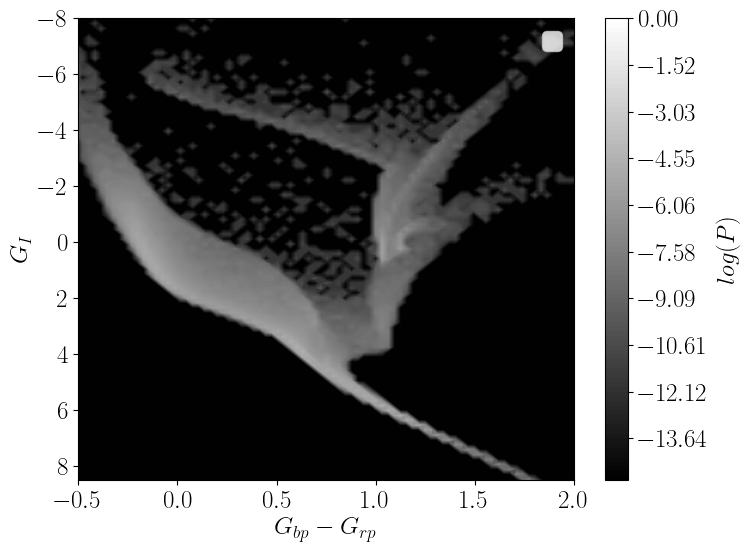

In [165]:
lower_limit = -15
posterior_truncated = posterior_sharp.copy()
mask = np.log(posterior_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

posterior_truncated[mask] = np.e**lower_limit


plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.log(posterior_truncated.T), levels=np.linspace(-15, 0, 100), cmap='grey')
plt.colorbar(label='$log(P)$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.5, 2)
plt.ylim(8.5, -8)
plt.legend()
plt.show()

In [159]:
lower_limit = -15
posterior_truncated = posterior.copy()
mask = np.log(posterior_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

posterior_truncated[mask] = np.e**lower_limit


Number of elements to replace: 4767


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_47493/3145138317.py:3: RuntimeWarning: divide by zero encountered in log
  mask = np.log(posterior_truncated) < lower_limit


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_47493/1436790264.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


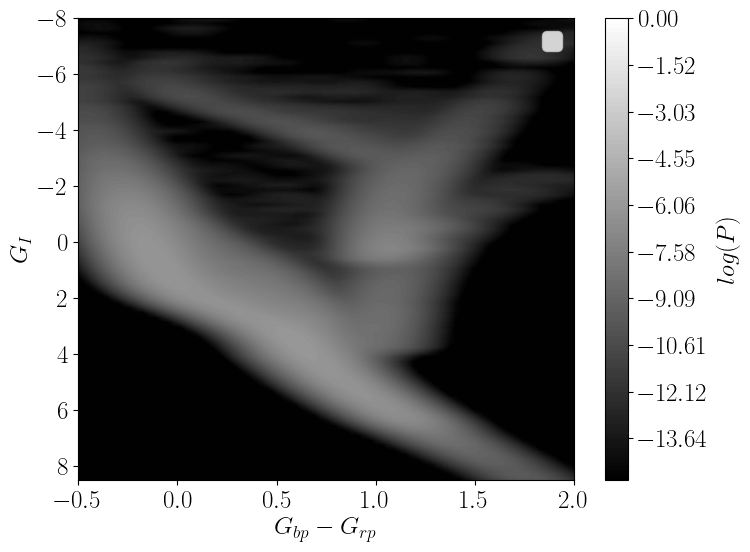

In [161]:
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.log(posterior_truncated.T), levels=np.linspace(lower_limit, 0, 100), cmap='grey')
plt.colorbar(label='$log(P)$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.5, 2)
plt.ylim(8.5, -8)
plt.legend()
plt.show()

## 2D histogram with Scott bins

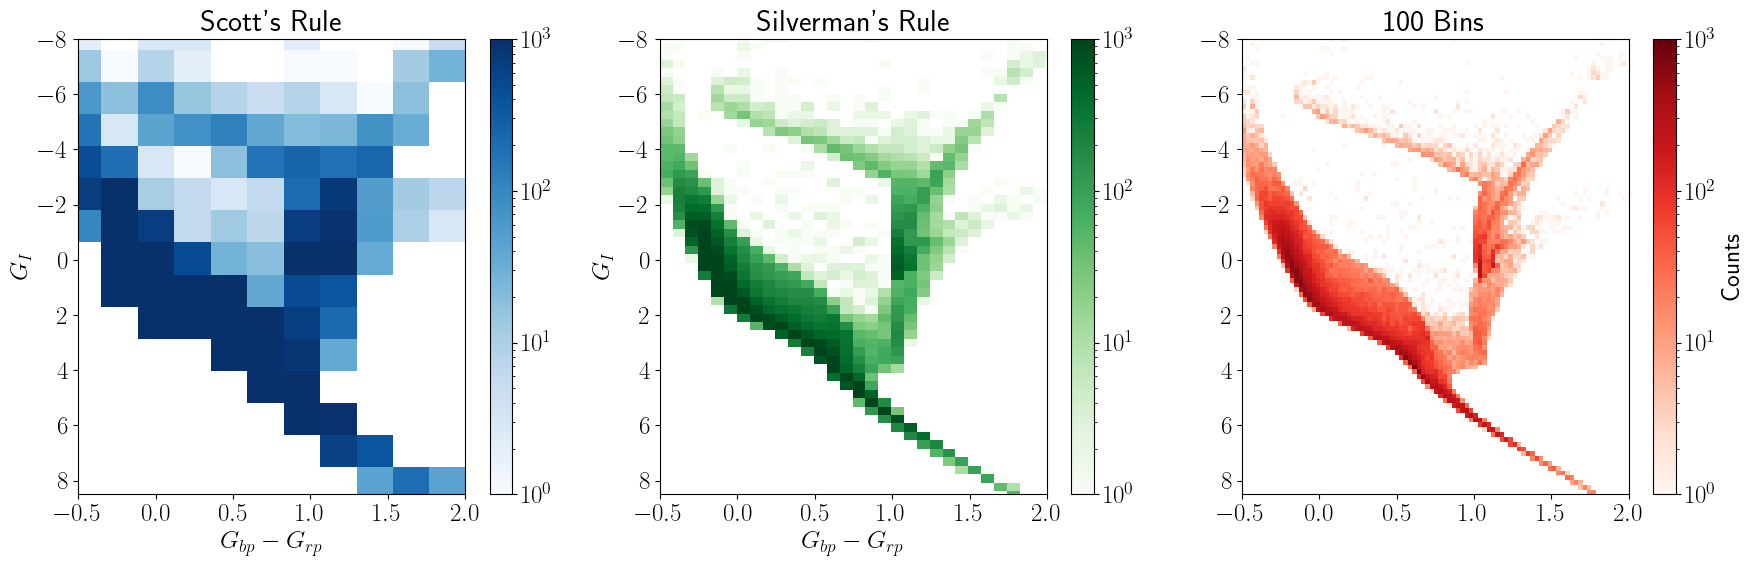

In [108]:
# Define ranges and statistics
x_range = X_data.max() - X_data.min()
y_range = Y_data.max() - Y_data.min()
n = len(X_data)
sigma_x, sigma_y = np.std(X_data), np.std(Y_data)

# Scott's rule
h_x_scott = 3.5 * sigma_x / n**(1/6)
h_y_scott = 3.5 * sigma_y / n**(1/6)
bins_x_scott = int(np.ceil(x_range / h_x_scott))
bins_y_scott = int(np.ceil(y_range / h_y_scott))

# Silverman's rule
h_x_silverman = (4 * sigma_x**5 / (3 * n))**(1/6)
h_y_silverman = (4 * sigma_y**5 / (3 * n))**(1/6)
bins_x_silverman = int(np.ceil(x_range / h_x_silverman))
bins_y_silverman = int(np.ceil(y_range / h_y_silverman))
# Generate 2D histogram


# set the colorbars to log scale
norm = colors.LogNorm(vmin=1, vmax=1000)

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scott's rule
h1 = axs[0].hist2d(X_data, Y_data, bins=[bins_x_scott, bins_y_scott], cmap='Blues', norm=norm)
axs[0].set_title("Scott's Rule")

# Silverman's rule
axs[1].hist2d(X_data, Y_data, bins=[bins_x_silverman, bins_y_silverman], cmap='Greens', norm=norm)
axs[1].set_title("Silverman's Rule")

# 100 bins
axs[2].hist2d(X_data, Y_data, bins=100, cmap='Reds', norm=norm)
axs[2].set_title("100 Bins")


axs[0].set_xlabel("$G_{bp} - G_{rp}$")
axs[0].set_ylabel("$G_{I}$")
axs[1].set_xlabel("$G_{bp} - G_{rp}$")
axs[1].set_ylabel("$G_{I}$")

axs[0].set_xlim(-0.5, 2)
axs[0].set_ylim(8.5, -8)
axs[1].set_xlim(-0.5, 2)
axs[1].set_ylim(8.5, -8)
axs[2].set_xlim(-0.5, 2)
axs[2].set_ylim(8.5, -8)

# add colorbars
fig.colorbar(axs[0].collections[0], ax=axs[0])#, label='Counts')
fig.colorbar(axs[1].collections[0], ax=axs[1])#, label='Counts')
fig.colorbar(axs[2].collections[0], ax=axs[2], label='Counts')
# Add a single colorbar in grey scale

plt.tight_layout()
plt.show()

### Uncertainties

Since the previous method requires uncertainties to be somewhat meaningfull. We will now analyze the unceratinties in both the color and the implied absolute magntiude. For the color we will propagate the photometric uncertainty and the extinction uncertainty. Thought I have no idea at the moment on how the extinction should be considered.

Lets begin by computing the absolute magntiude with errors from the distance and the flux error, where:

## $\delta M_g = \sqrt{((\frac{2.5}{ln(10)}) \frac{\delta f}{f})^2 + (\frac{5\delta d}{ln(10)d})^2} $

In [10]:
import numpy as np

def get_abs_g_magnitude(g_app, g_flux, flux_err_g, dist_pc, dist_err_pc):
    """
    Convert an apparent G magnitude + flux error + distance + distance error
    into an absolute G magnitude and its uncertainty, under the assumption
    of no extinction.

    Parameters
    ----------
    g_app       : float or ndarray
        Apparent G-band magnitude.
    flux_err_g  : float or ndarray
        Flux error in the G band, in the same flux units used to define g_app.
        (i.e., if g = -2.5 log10(F) + ZP, then flux_err_g is the error on F.)
    dist_pc     : float or ndarray
        Distance in parsecs.
    dist_err_pc : float or ndarray
        Error on the distance, in parsecs.

    Returns
    -------
    M_g    : float or ndarray
        Absolute G-band magnitude.
    eM_g   : float or ndarray
        Uncertainty in the absolute G-band magnitude.

    Notes
    -----
    1) We compute the magnitude error from the flux error via:
         d(g) = 2.5 / (ln(10) * F) * dF,
       where F = 10^(-0.4*g).

    2) Then we do the usual formula for absolute magnitude, M = g - 5 log10(d) + 5,
       and propagate errors from both g and d.

    3) For large uncertainties or correlated parameters, a more complete
       Monte Carlo or Bayesian approach may be necessary.

    4) If you're already provided with an error in g (instead of flux_err_g),
       you can skip the flux-based step and directly use that error.
    """
    # Convert inputs to arrays if they are single floats
    g_app     = np.atleast_1d(g_app)
    flux_err_g = np.atleast_1d(flux_err_g)
    dist_pc   = np.atleast_1d(dist_pc)
    dist_err_pc = np.atleast_1d(dist_err_pc)

    # Flux corresponding to g_app
    #   F = 10^(-0.4*g_app)
    F_g = g_flux

    # Magnitude error from flux error:
    #   e_g = (2.5 / (ln(10) * F)) * flux_err
    ln10 = np.log(10.0)
    e_g  = (2.5 / (ln10 * F_g)) * flux_err_g   # same shape as g_app

    # Absolute magnitude M_g
    #   M_g = g_app - 5 log10(dist_pc) + 5
    M_g = g_app - 5.0 * np.log10(dist_pc) + 5.0

    # Error in M_g
    #   e_M^2 = e_g^2 + [ -5/(dist ln(10)) * dist_err ]^2
    term_dist = (5.0 / (dist_pc * ln10)) * dist_err_pc
    e_M_g = np.sqrt(e_g**2 + term_dist**2)

    return M_g, e_M_g


To test the previous function we need some Gaia data so that we can compute uncertainties

In [6]:
from astropy.table import Table
# load gaia data for HEALPix pixel 2161 copied directly from ALICE
gaia_data = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/gaia_by_healpix/healpix_2161.fits')


We will compute the implied distance and velocity so that we can then compute the uncertainties

In [7]:
# Add the path to the 'scripts' folder directly
#sys.path.append('/Users/mncavieres/Documents/2024-2/HVS/scripts')  # Add scripts folder to path

# Now you can import from the 'scripts' package
#from implied_d_vr import implied_calculations

In [16]:
gaia_data_ = implied_calculations(gaia_data)

gaia_data['bp_rp'] = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

In [17]:
# This data still needs to be prepared by correcting extinction and setting the columns in the right format
#  I will be modifying this function for this purpose
def prepare_gaia(data_gaia_big, subsample='all'):
    """ 
    Construct a training catalog for classification containing a mix of gaia data and speedystar HVS with labels
    
    input:
        data_gaia: dataframe containing gaia data
        simulated_catalog_f: astropy table containing speedystar data

    output:
        data_gaia: pandas dataframe containing gaia data

    """
    
    # Read the simulated catalog if a path is passed
    if isinstance(data_gaia_big, str):
        data_gaia_big = Table.read(data_gaia_big)
        data_gaia_big = data_gaia_big.to_pandas()
    
    # check if the data is an astropy table and convert it to a pandas dataframe
    if isinstance(data_gaia_big, Table):
        data_gaia_big = data_gaia_big.to_pandas()

    # check if the required columns are present in the data
    columns_required = ['ra', 'dec', 'bp_rp', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error']
    if not all([col in data_gaia_big.columns for col in columns_required]):
        raise ValueError(f"Required columns missing in the data. Required columns are {columns_required}")

    # Select a random subsample of the simulated catalog
    if not subsample == 'all':
        data_gaia_big = data_gaia_big[np.random.choice(len(data_gaia_big), subsample)]
    
    
    # compute implied quantities 
    data_gaia_big = implied_calculations(data_gaia_big)

    # keep only positive implied parallaxes
    data_gaia_big = data_gaia_big.loc[data_gaia_big['implied_parallax'] > 0]

    # add extinction correction
    data_gaia_big = extinction_correction(data_gaia_big)

    # compute implied absolute magnitudes
    data_gaia_big['implied_M_g'], data_gaia_big['implied_M_g_error'] = get_abs_g_magnitude(data_gaia_big['phot_g_mean_mag'], 
                                                                                           data_gaia_big['phot_g_mean_flux'],
                                                                                             data_gaia_big['phot_g_mean_flux_error'], 
                                                                                             data_gaia_big['implied_distance'], 
                                                                                             data_gaia_big['implied_distance_error'])

    # correct the absolute magnitude for extinction
    data_gaia_big['implied_M_g_corr'] = data_gaia_big['implied_M_g'] - data_gaia_big['A_G']

    # compute bp_rp_corr_error
    #data_gaia_big['bp_rp_corr_error'] = 
    return data_gaia_big

In [18]:
gaia_data_prepared = prepare_gaia(gaia_data)

Now we need a way to compute the bp - rp uncertainty

In [20]:
def bp_rp_uncertainty(phot_bp_mean_flux, phot_bp_mean_flux_error, phot_rp_mean_flux, phot_rp_mean_flux_error):
    """
    Compute the uncertainty in the bp_rp color from the fluxes and their errors
    """
    # compute the color
    bp_rp = -2.5*np.log10(phot_bp_mean_flux/phot_rp_mean_flux)
    
    # compute the error in the color
    bp_rp_error = np.sqrt((2.5/np.log(10))**2 * (phot_bp_mean_flux_error/phot_bp_mean_flux)**2 + (2.5/np.log(10))**2 * (phot_rp_mean_flux_error/phot_rp_mean_flux)**2)
    
    return bp_rp, bp_rp_error

In [21]:
gaia_data_prepared['bp_rp_error'] = bp_rp_uncertainty(gaia_data_prepared['phot_bp_mean_flux'], gaia_data_prepared['phot_bp_mean_flux_error'], gaia_data_prepared['phot_rp_mean_flux'], gaia_data_prepared['phot_rp_mean_flux_error'])[1]

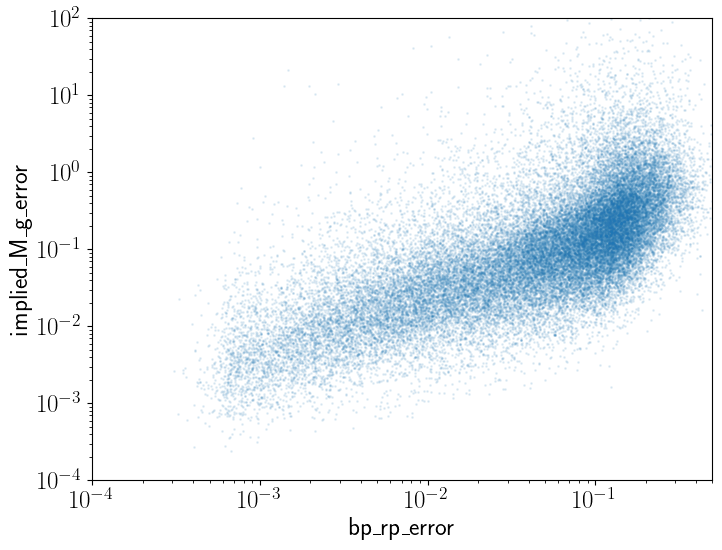

In [51]:
# visualize the error distribution
plt.figure(figsize=(8, 6))
plt.scatter(gaia_data_prepared['bp_rp_error'], gaia_data_prepared['implied_M_g_error'], s=1, alpha= 0.1)
plt.xlabel('bp_rp_error')
plt.ylabel('implied_M_g_error')
plt.ylim(1e-4, 1e2)
plt.xlim(1e-4, 0.5)
plt.yscale('log')
plt.xscale('log')
plt.show()

Now this data has everything to define the Gaussian kernel that will be convolved with the CMD

In [120]:
from scipy.ndimage import gaussian_filter


# Generate 2D histogram
bin_count = 100
hist, x_edges, y_edges = np.histogram2d(X_data, Y_data, bins=bin_count, density=True)

# Convolve histogram with Gaussian kernel defined by the mean color and magnitude errors
error_x = gaia_data_prepared['bp_rp_error'].median()
error_y = gaia_data_prepared['implied_M_g_error'].median()
sigma_x = error_x * bin_count / (np.max(X_data) - np.min(X_data))
sigma_y = error_y * bin_count / (np.max(Y_data) - np.min(Y_data))
smoothed_hist = gaussian_filter(hist, sigma=[sigma_x, sigma_y])

# Normalize posterior probability (optional)
posterior = smoothed_hist / np.sum(smoothed_hist)
posterior_sharp = hist / np.sum(hist)

# Plot posterior
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_10157/3411595697.py:3: RuntimeWarning: divide by zero encountered in log
  mask = np.log(posterior_truncated) < lower_limit


Number of elements to replace: 5084


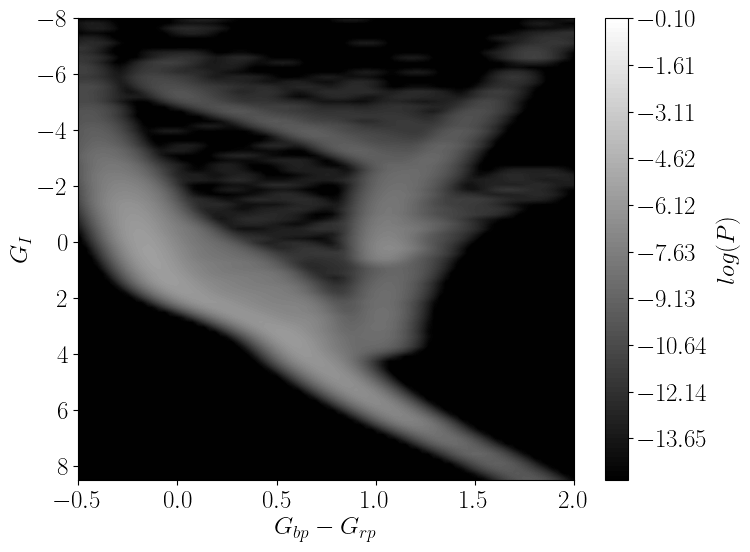

In [155]:
lower_limit = -15
posterior_truncated = posterior.copy()
mask = np.log(posterior_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

posterior_truncated[mask] = np.e**lower_limit

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.log(posterior_truncated.T), levels=np.linspace(lower_limit, -0.1, 100), cmap='grey')
plt.colorbar(label='$log(P)$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.5, 2)
plt.ylim(8.5, -8)
#plt.legend()
plt.show()

Now this same procedure needs to be applied to the background, except that the background already has all the errors built in right????

In [122]:
gaia_data_prepared.dropna(subset=['bp_rp', 'implied_M_g'], inplace=True)

In [123]:
data_gaia_prepared_sliced = gaia_data_prepared.loc[(gaia_data_prepared['bp_rp'] < 2) &
                                                    (gaia_data_prepared['bp_rp']> -0.5) &
                                                    (gaia_data_prepared['implied_M_g'] < 8.5) &
                                                    (gaia_data_prepared['implied_M_g'] > -8)]

Number of elements to replace: 0


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_10157/2694319545.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


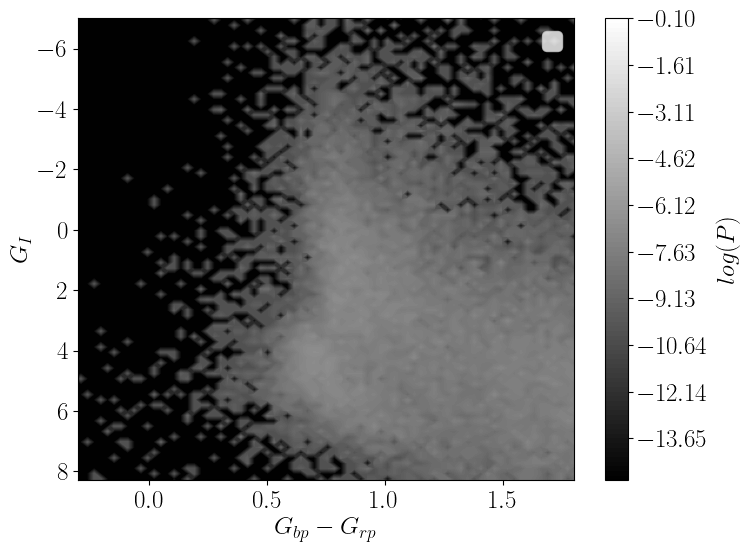

In [128]:
from scipy.ndimage import gaussian_filter


# Generate 2D histogram
bin_count = 100
#hist, x_edges, y_edges = np.histogram2d(data_gaia_prepared_sliced['bp_rp'], data_gaia_prepared_sliced['implied_M_g'],
#                                         bins=bin_count, density=True)

hist, x_edges, y_edges = np.histogram2d(data_gaia_prepared_sliced['bp_rp'], data_gaia_prepared_sliced['implied_M_g'],bins = [x_edges, y_edges], density=True)

# Normalize posterior probability (optional)
posterior_sharp_background = hist / np.sum(hist)

# Plot posterior
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)

lower_limit = -15
posterior_truncated_background = posterior_sharp_background.copy()
mask = np.log(posterior_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

posterior_truncated[mask] = np.e**lower_limit

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.log(posterior_truncated.T), levels=np.linspace(lower_limit, -0.1, 100), cmap='grey')
#plt.contourf(X, Y, posterior_truncated.T, levels=100, cmap='grey')
plt.colorbar(label='$log(P)$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.3, 1.8)
plt.ylim(8.3, -7)
plt.legend()
plt.show()

In [146]:
# division of both posteriors

# Generate 2D histogram for the model
bin_count = 100
hist, x_edges, y_edges = np.histogram2d(X_data, Y_data, bins=bin_count, density=True)

# Convolve histogram with Gaussian kernel defined by the mean color and magnitude errors
error_x = gaia_data_prepared['bp_rp_error'].median()
error_y = gaia_data_prepared['implied_M_g_error'].median()
sigma_x = error_x * bin_count / (np.max(X_data) - np.min(X_data))
sigma_y = error_y * bin_count / (np.max(Y_data) - np.min(Y_data))
smoothed_hist = gaussian_filter(hist, sigma=[sigma_x, sigma_y])

# Normalize posterior probability (optional)
posterior = smoothed_hist / np.sum(smoothed_hist)
posterior_sharp = hist / np.sum(hist)

# Generate 2D histogram for the background being careful to use the same bins as the model

hist, x_edges, y_edges = np.histogram2d(data_gaia_prepared_sliced['bp_rp'], 
                                        data_gaia_prepared_sliced['implied_M_g'],
                                        bins = [x_edges, y_edges], density=True)
# Normalize posterior probability (optional)
posterior_background = hist / np.sum(hist)

# divide the two posteriors to get the likelihood ratio taking care of the zeros
likelihood_ratio = np.divide(posterior, posterior_background, out=np.ones_like(posterior), where=posterior_background!=0)

likelihood_ratio_sharp = np.divide(posterior_sharp, posterior_background, out=np.ones_like(posterior), where=posterior_background!=0)

# smooth the likelihood ratio
likelihood_ratio_smoothed = gaussian_filter(likelihood_ratio_sharp, sigma=[sigma_x, sigma_y])



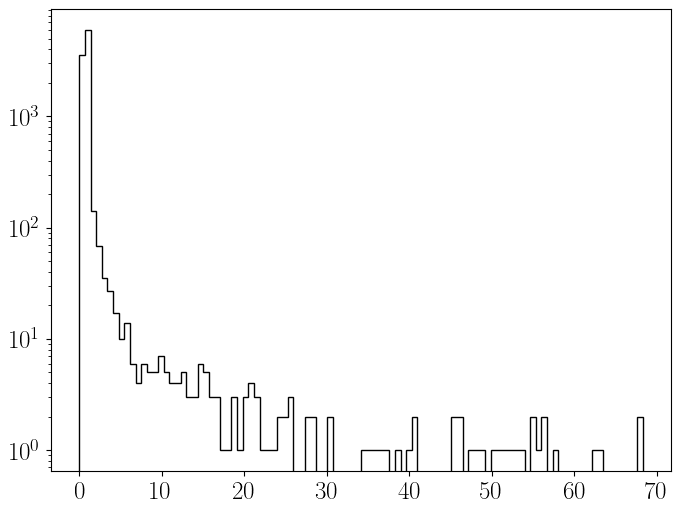

In [143]:
plt.figure(figsize=(8, 6))
plt.hist(likelihood_ratio.flatten(), bins=100, histtype='step', color='k')
plt.yscale('log')
plt.show()

Number of elements to replace: 482


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_10157/1704665882.py:3: RuntimeWarning: divide by zero encountered in log
  mask = np.log(likelihood_ratio_truncated) < lower_limit


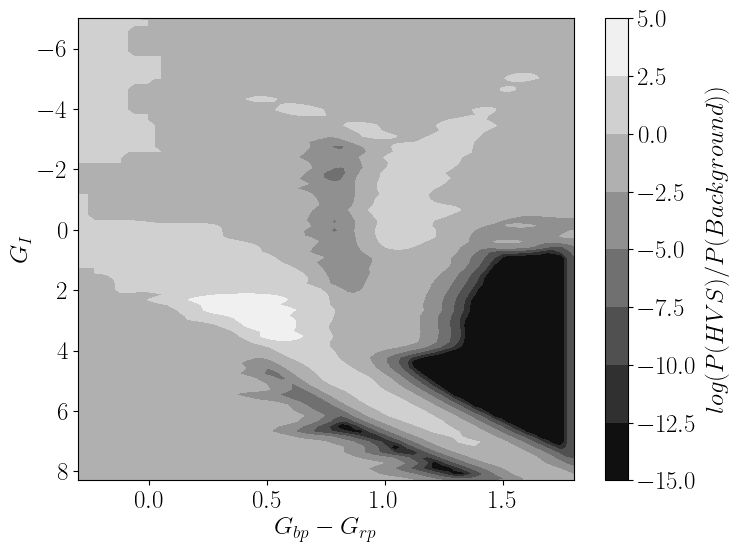

In [154]:
lower_limit = -15
likelihood_ratio_truncated = likelihood_ratio_smoothed.copy()
mask = np.log(likelihood_ratio_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

likelihood_ratio_truncated[mask] = np.e**lower_limit

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, np.log(likelihood_ratio_truncated.T), cmap='grey')
#plt.contourf(X, Y, posterior_truncated.T, levels=100, cmap='grey')
plt.colorbar(label='$log(P(HVS) / P(Background))$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.3, 1.8)
plt.ylim(8.3, -7)
#plt.legend()
plt.show()

Number of elements to replace: 482


/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_10157/601803991.py:3: RuntimeWarning: divide by zero encountered in log
  mask = np.log(likelihood_ratio_truncated) < lower_limit


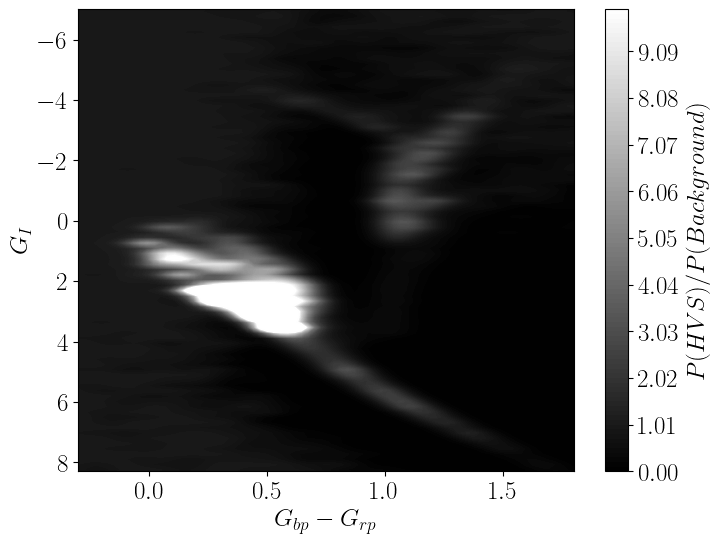

In [152]:
lower_limit = -15
likelihood_ratio_truncated = likelihood_ratio_smoothed.copy()
mask = np.log(likelihood_ratio_truncated) < lower_limit
print("Number of elements to replace:", np.sum(mask))

likelihood_ratio_truncated[mask] = np.e**lower_limit

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, likelihood_ratio_truncated.T, cmap='grey', levels = np.linspace(0, 10, 100))
#plt.contourf(X, Y, posterior_truncated.T, levels=100, cmap='grey')
plt.colorbar(label='$P(HVS) / P(Background)$')
#plt.scatter(X_data, Y_data, c='red', s=5, alpha=0.5, label='Data Points')
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
#plt.title('$log(P)$')
plt.xlim(-0.3, 1.8)
plt.ylim(8.3, -7)

plt.show()